# import torch

In [1]:
import torch
torch.__version__

'1.10.1+cu113'

# GPU check

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Download MNIST dataset

## What is MNIST dataset?
> MNIST 데이터베이스 (Modified National Institute of Standards and Technology database)는  
손으로 쓴 숫자들로 이루어진 대형 데이터베이스이며,   
다양한 화상 처리 시스템을 트레이닝하기 위해 일반적으로 사용된다.   
이 데이터베이스는 또한 기계 학습 분야의 트레이닝 및 테스트에 널리 사용된다.  
>  
> https://ko.wikipedia.org/wiki/MNIST_데이터베이스

In [3]:
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt

train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)


In [4]:
# train data 특성
print(train_data)
print(train_data.data.size())

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
torch.Size([60000, 28, 28])


In [5]:
# 데이터에 어떤 내용이 있는지 확인
img, label = train_data[0]
print(img.shape)
print(label)

torch.Size([1, 28, 28])
5


In [6]:
import matplotlib.pyplot as plt
def draw(image, label):
    pixels = image.reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.title(f"{label}")
    plt.show()

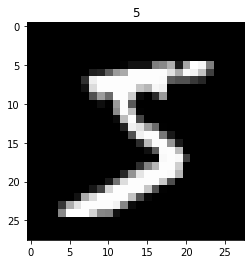

In [7]:
draw(img, label)

# Plot multiple train_data

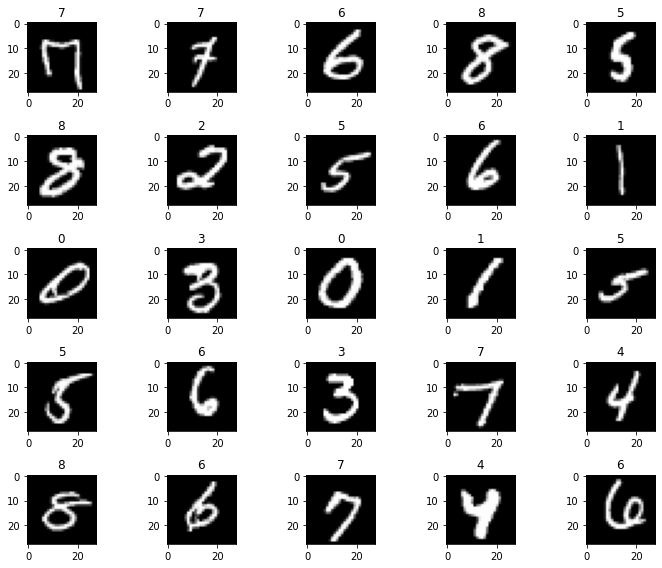

In [8]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = np.random.randint(len(train_data), size=(1,)).item()   # 임의의 숫자 1개 
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)    
    #plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
    
plt.tight_layout()
plt.show()

# Dataloader

In [9]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, ),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x1f29a1eaa60>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x1f29a1eab20>}

# Defile Model

In [10]:
import torch.nn as nn
import torch.nn.functional as F
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=32,            
                kernel_size=3,              
                stride=1,                   
                padding=1,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(32, 64, 3, 1, 1),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(64 * 7 * 7, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)

        return output    # return x for visualization

In [11]:
cnn = CNN()
cnn.to(device)
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=3136, out_features=10, bias=True)
)


In [12]:
#!pip install torchsummary
from torchsummary import summary
summary(cnn, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Linear-7                   [-1, 10]          31,370
Total params: 50,186
Trainable params: 50,186
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.65
Params size (MB): 0.19
Estimated Total Size (MB): 0.84
----------------------------------------------------------------


In [13]:
import matplotlib.pyplot as plt
def draw(image, label):
    pixels = image.reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.title(f"{label}")
    plt.show()

In [14]:
import random
def show_predict(model):
    idx = random.randrange(0, len(test_data)-1)    # 임의의 정수 1개 
    image, gt = test_data[idx]                     # image하고 gt 가져오기
    image = image.to(device)                       
    predicted = model(image.reshape(1,1,28,28))    # 모델에 이미지 넣은 결과값 -> predicted.shape = (10, )
    confidence, label = torch.max(predicted, 1)    # 가장 큰 1개 값의 confidence와 label(class) 가져오기
    #label = torch.argmax(predicted).cpu().item()
    print("idx:", idx)
    print("predicted:", predicted)
    print("confidence:", confidence)
    print("label:", label)
    draw(image.cpu(), label.item())

idx: 3060
predicted: tensor([[-0.0041, -0.0684,  0.0693, -0.0740, -0.0575, -0.0276,  0.0262,  0.1226,
         -0.0608, -0.0334]], device='cuda:0', grad_fn=<AddmmBackward0>)
confidence: tensor([0.1226], device='cuda:0', grad_fn=<MaxBackward0>)
label: tensor([7], device='cuda:0')


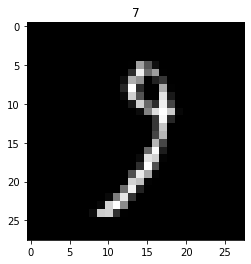

In [15]:
show_predict(cnn)

# Define loss function

In [16]:
loss_func = nn.CrossEntropyLoss()   
loss_func

CrossEntropyLoss()

# Define optimizer

In [17]:
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

# Train model

In [18]:
from torch.autograd import Variable
num_epochs = 3

def train(num_epochs, cnn, loaders):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            images = images.to(device, dtype=torch.float32)
            labels = labels.to(device)
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y

            output = cnn(b_x)             

            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                pass
        
        pass
    
    
    pass
train(num_epochs, cnn, loaders)

Epoch [1/3], Step [100/600], Loss: 0.1789
Epoch [1/3], Step [200/600], Loss: 0.1575
Epoch [1/3], Step [300/600], Loss: 0.1557
Epoch [1/3], Step [400/600], Loss: 0.1315
Epoch [1/3], Step [500/600], Loss: 0.0623
Epoch [1/3], Step [600/600], Loss: 0.0543
Epoch [2/3], Step [100/600], Loss: 0.0424
Epoch [2/3], Step [200/600], Loss: 0.0274
Epoch [2/3], Step [300/600], Loss: 0.0248
Epoch [2/3], Step [400/600], Loss: 0.0423
Epoch [2/3], Step [500/600], Loss: 0.0849
Epoch [2/3], Step [600/600], Loss: 0.1071
Epoch [3/3], Step [100/600], Loss: 0.0092
Epoch [3/3], Step [200/600], Loss: 0.0281
Epoch [3/3], Step [300/600], Loss: 0.2127
Epoch [3/3], Step [400/600], Loss: 0.0869
Epoch [3/3], Step [500/600], Loss: 0.0496
Epoch [3/3], Step [600/600], Loss: 0.0293


# Evaluate

In [19]:
def evaluate():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            images = images.to(device, dtype=torch.float32)
            labels = labels.to(device)
            test_output = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass

        print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)
    
    pass
evaluate()

Test Accuracy of the model on the 10000 test images: 0.98


# Evaluation data sampling

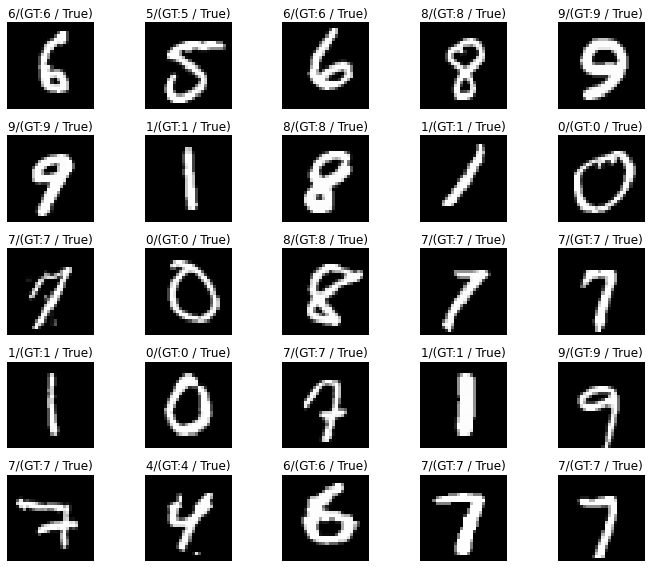

In [20]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    cnn.eval()
    sample_idx = np.random.randint(len(test_data), size=(1,)).item()
    img, gt = test_data[sample_idx]
    img = img.to(device)
    predicted = cnn(img.view(1,1,28,28))
    #label = torch.argmax(predicted)
    confidence, label = torch.max(predicted, 1)
    label = label.cpu().item()
    figure.add_subplot(rows, cols, i)
    plt.title(f"{label}/(GT:{gt} / {gt==label})")
    plt.axis("off")
    plt.imshow(img.view(28,28).cpu(), cmap="gray")

plt.tight_layout()
plt.show()

# Test

idx: 2123
predicted: tensor([[ -8.1680,  -2.3056,  -1.0813,   3.7015,  -7.2248,  -4.1644, -17.1081,
           9.4336,  -0.1111,   2.6201]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
confidence: tensor([9.4336], device='cuda:0', grad_fn=<MaxBackward0>)
label: tensor([7], device='cuda:0')


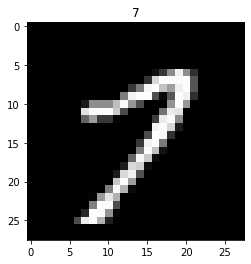

In [21]:
show_predict(cnn)